In [4]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
triangle_graph = nx.from_edgelist([(1, 2), (2, 3), (3, 1)], create_using=nx.DiGraph)

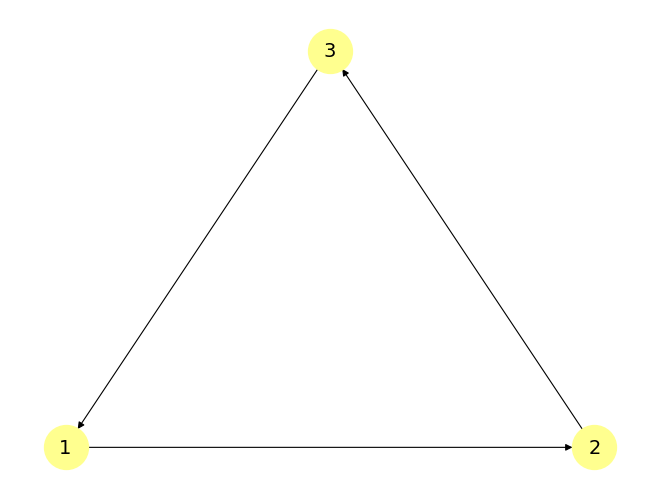

In [6]:
nx.draw_planar(
    triangle_graph,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.8,
    font_size=14,
)

In [12]:
G = nx.DiGraph()

In [13]:
#G.add_node("ModelX")
#G.add_node("ModelY")
G.add_edge("ModelX", "ModelY")

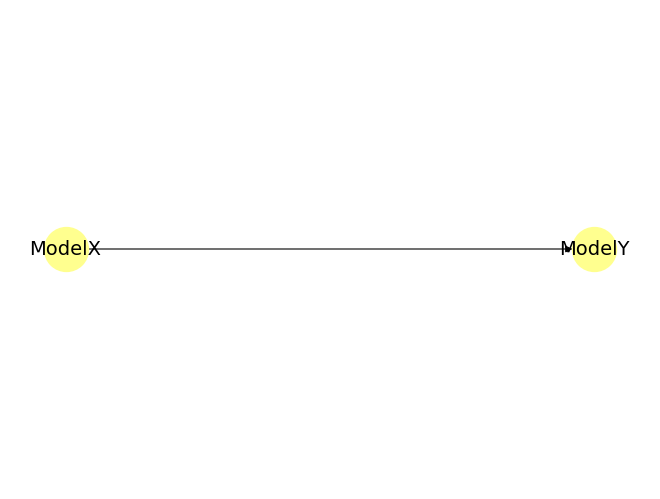

In [14]:
nx.draw_planar(
    G,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.8,
    font_size=14,
)

In [96]:
import re
from typing import Optional

import networkx as nx
from pydantic import create_model, BaseModel


#init
INITIALIZED_MODELS = {}

class DependencyDict(dict):
    G = nx.DiGraph()
    failure = {}
    
    @staticmethod
    def get_model_from_str(field: str):
        print(field)
        m = re.search(r"\(([A-Z'a-z0-9_]+)\)", field)
        return m.group(1).replace("'", "")
    
    
    def resolve_dependency_graph(self):
        if not LOOKUP.G.is_directed():
            raise ValueError("Can only resolve directed dependencies.")
        for n in nx.topological_sort(self.G):
            print(f"resolving dependency {n}")
            model = str(n)
            if model in self.failure:
                fields = self.failure[model]
                self.__setitem__(model, fields)
            else:
                if not model in INITIALIZED_MODELS:
                    raise ValueError("unknown error. model is not in initialized models or failures!")
        
            
  
    def __setitem__(self, *args, **kwargs):
        failed = False
        model, fields =  args
        for field_key, types in fields.items():
            if  isinstance(types[0], str):
                if not "dynamic_creation" in types[0]:
                    raise ValueError("Unhandled situation")
                try:
                    initialized = eval(types[0])
                    print(f"initialized model: {model}")
                except KeyError as e:
                    print(f"cannont initialize {model} at this time. Will create dependency graph and execute later.")
                    self.G.add_edge(model, self.get_model_from_str(types[0]))
                    failed = True
        if failed:
            self.failure[model] = fields
        else:
            super().__setitem__(*args, **kwargs)
        
        

LOOKUP = DependencyDict()


def dynamic_creation(model: str):
    if model not in INITIALIZED_MODELS:
        fields = LOOKUP[model]
        dynamic_creation = create_model(model, __base__=BaseModel, **fields)
        INITIALIZED_MODELS[model] = dynamic_creation
        return dynamic_creation
    else:
        return INITIALIZED_MODELS[model]

    
LOOKUP["ModelY"] =  {'field4': (str, None), 'field5': (Optional[str], None)}
LOOKUP["ModelX"] =  {'field4': (str, None), 'field5': (Optional[str], None)}
LOOKUP["ModelA"] =  {'field1': (str, None), 'field2': (Optional[str], None), "field3": ("dynamic_creation('ModelZ')", None)}
LOOKUP["ModelX"] =  {'field1': (str, None), 'field2': (Optional[str], None), "field3": ("dynamic_creation('ModelZ')", None)}
LOOKUP["ModelZ"] =  {'field1': (str, None), 'field2': (Optional[str], None), "field4": ("dynamic_creation('ModelN')", None)}
LOOKUP["ModelN"] =  {'field1': (str, None), 'field2': (Optional[str], None), "field4": ("dynamic_creation('ModelY')", None)}


LOOKUP.resolve_dependency_graph()
#dynamic_creation("ModelA")
ModelZ = dynamic_creation("ModelZ")
ModelX = dynamic_creation("ModelX")


cannont initialize ModelA at this time. Will create dependency graph and execute later.
dynamic_creation('ModelZ')
cannont initialize ModelX at this time. Will create dependency graph and execute later.
dynamic_creation('ModelZ')
cannont initialize ModelZ at this time. Will create dependency graph and execute later.
dynamic_creation('ModelN')
initialized model: ModelN
resolving dependency ModelA
cannont initialize ModelA at this time. Will create dependency graph and execute later.
dynamic_creation('ModelZ')
resolving dependency ModelX
cannont initialize ModelX at this time. Will create dependency graph and execute later.
dynamic_creation('ModelZ')
resolving dependency ModelZ
initialized model: ModelZ
resolving dependency ModelN


In [100]:
ModelX.schema_json()

'{"title": "ModelX", "type": "object", "properties": {"field4": {"title": "Field4", "type": "string"}, "field5": {"title": "Field5", "type": "string"}}}'

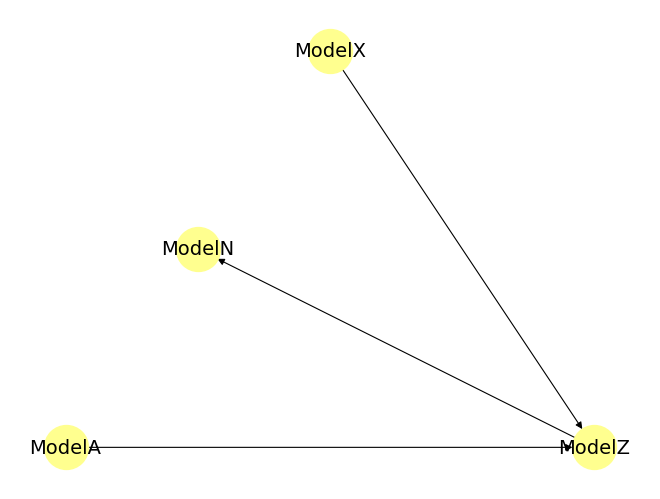

In [93]:
nx.draw_planar(
    LOOKUP.G,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.8,
    font_size=14,
)

In [71]:
LOOKUP.G.is_directed()

True

In [80]:
for n in nx.topological_sort(LOOKUP.G):
    print(n)

ModelA
ModelX
ModelZ
ModelN
ModelY


In [78]:
for n, nbrsdict in nx.topological_sort(LOOKUP.G).adjacency():
    print("n",n , nx.ancestors(LOOKUP.G, n))
    #print(nbrsdict)
#     for nbr, eattr in nbrsdict.items():
#         print(nbr)

AttributeError: 'generator' object has no attribute 'adjacency'

In [84]:
for n in LOOKUP.G:
    x = n

In [85]:
x.s

'ModelY'